# Rehearse Right: A Real-Time AI-Based Emotion Recognition and Feedback for Public Speaking Training Capstone Project.

## Part 2: Speech Emotion Detection Classifier using CREAMAD, RAVDESS, SURREY and TESS Datasets

* #### Crowd-sourced Emotional Mutimodal Actors Dataset **(CREMA-D)**
* #### Ryerson Audio-Visual Database of Emotional Speech and Song **(RAVDESS)**
* #### Surrey Audio-Visual Expressed Emotion **(SAVEE)**
* #### Toronto emotional speech set **(TESS)**

### Step 1: Importing required libraries

In [1]:
!apt-get update

Get:1 http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1581 B]
Get:2 http://packages.cloud.google.com/apt gcsfuse-bionic InRelease [1231 B]   
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease                        
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [102 kB]     
Ign:5 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Err:1 http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
  The following signatures couldn't be verified because the public key is not available: NO_PUBKEY A4B469963BF863CC
Get:7 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:8 http://packages.cloud.google.com/apt cloud-sdk-bionic InRelease [1646 B] 
Get:9 http://archive.ubuntu.com/ubuntu bionic-up

In [2]:
!apt-get install -y libsndfile1

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libflac8 libogg0 libvorbis0a libvorbisenc2
The following NEW packages will be installed:
  libflac8 libogg0 libsndfile1 libvorbis0a libvorbisenc2
0 upgraded, 5 newly installed, 0 to remove and 237 not upgraded.
Need to get 557 kB of archives.
After this operation, 2051 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libogg0 amd64 1.3.2-1 [17.2 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libflac8 amd64 1.3.2-1ubuntu0.1 [213 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libvorbis0a amd64 1.3.5-4.2 [86.4 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main amd64 libvorbisenc2 amd64 1.3.5-4.2 [70.7 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libsndfile1 amd64 1.0.28-4ubuntu0.18.04.2 [170 kB]
Fetched 557 kB in 0s (2757 kB/s)  

In [3]:
# importing required libraries
import os
import sys
import librosa
import keras
import pandas as pd
import numpy as np
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from IPython.display import Audio
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [4]:
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### Step 2: Data Preparation

For this project, we are working with four different datasets. We will create a dataframe that consolidates all the emotions from the data along with their corresponding paths. This dataframe will serve as the basis for extracting features needed for model training

In [5]:
# setting paths for the dataset
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

In [6]:
# creating RAVDESS dataset DataFrame
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...

In [7]:
# creating CREMA D dataset DataFrame
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                               Path
0  disgust  /kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1    happy  /kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2    happy  /kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3  disgust  /kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4  disgust  /kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav

In [8]:
# Creating TESS dataset DataFrame
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0     fear  /kaggle/input/toronto-emotional-speech-set-tes...
1     fear  /kaggle/input/toronto-emotional-speech-set-tes...
2     fear  /kaggle/input/toronto-emotional-speech-set-tes...
3     fear  /kaggle/input/toronto-emotional-speech-set-tes...
4     fear  /kaggle/input/toronto-emotional-speech-set-tes...

In [9]:
# creating CREMA D dataset DataFrame
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                                               Path
0    happy  /kaggle/input/surrey-audiovisual-expressed-emo...
1     fear  /kaggle/input/surrey-audiovisual-expressed-emo...
2    happy  /kaggle/input/surrey-audiovisual-expressed-emo...
3  disgust  /kaggle/input/surrey-audiovisual-expressed-emo...
4    angry  /kaggle/input/surrey-audiovisual-expressed-emo...

In [10]:
# combining the four dataframes we created so far into a single consolidated dataframe.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...

### Step 3: Data Visualisation and Exploration

#### 3.1. Distribution of each emotions in our dataset

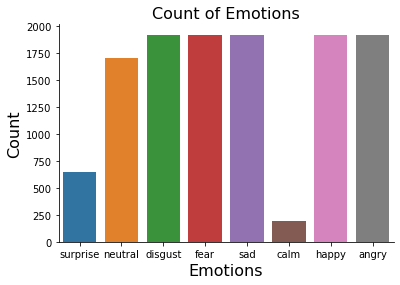

In [11]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=16)
plt.xlabel('Emotions', size=16)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

#### 3.2. Visualizing Audio Signals: Waveplots and Spectrograms
 * **Waveplots:** These plots depict the loudness of an audio signal over time, helping us analyze its amplitude dynamics.
* **Spectrograms:** A spectrogram visually represents the frequency spectrum of sound as it changes over time, providing insights into how frequencies evolve in audio or music signals.

In [12]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for Audio with {} Emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # The STFT (Short-Time Fourier Transform) function transforms the audio data into its short-term Fourier transform, enabling analysis of frequency components over small time intervals.
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for Audio with {} Emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

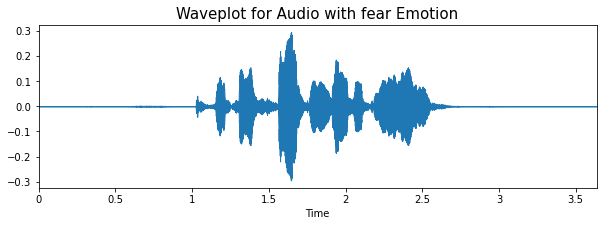

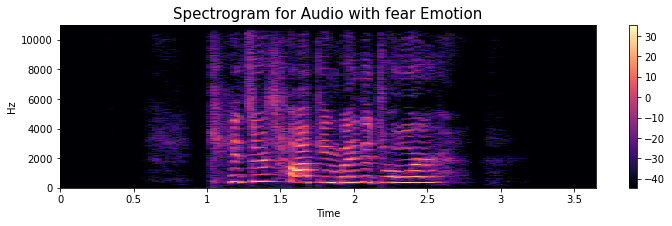

In [13]:
# visualizing Waveplot and Spectrogram for the audio with FEAR emotion
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

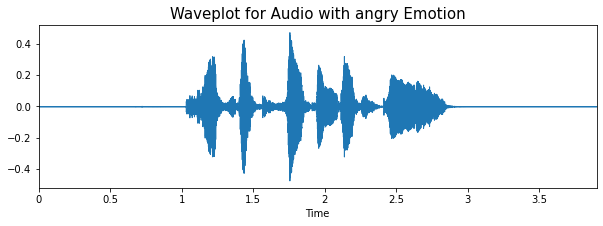

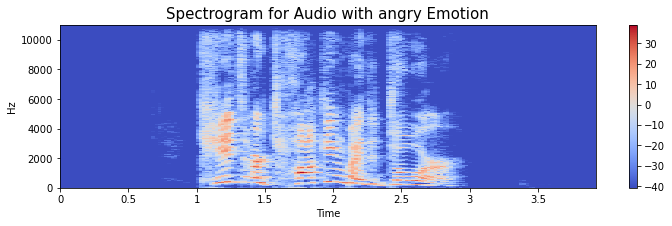

In [14]:
# visualizing Waveplot and Spectrogram for the audio with ANGRY emotion
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

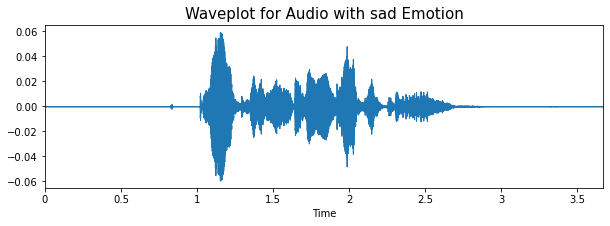

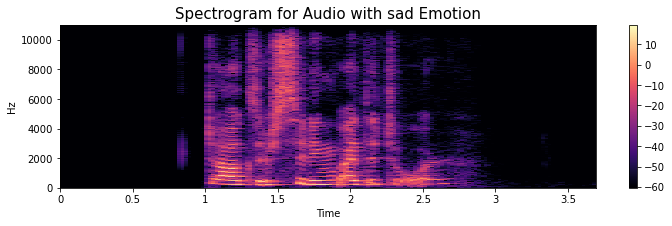

In [15]:
# visualizing Waveplot and Spectrogram for the audio with SAD emotion
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

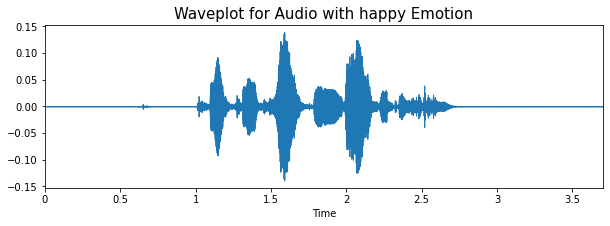

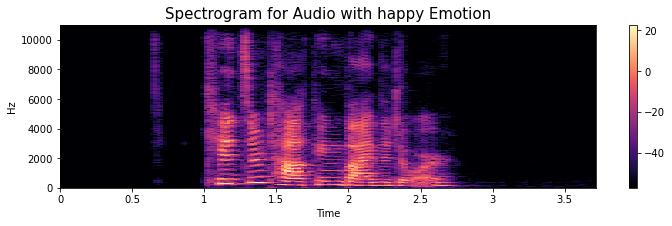

In [16]:
# visualizing Waveplot and Spectrogram for the audio with HAPPY emotion
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

### Step 4: Data Augmentation for Improved Model Generalization

Data augmentation involves creating synthetic data samples by introducing small perturbations to the original training set. For audio data, this can include techniques like noise injection, time shifting, and altering pitch or speed. These methods aim to make the model robust to such variations and enhance its generalization capabilities.

It is essential that the applied perturbations preserve the original label of the training sample to ensure effective learning. Similarly, for image data, augmentation can involve transformations such as shifting, zooming, or rotating.

We will begin by evaluating which augmentation techniques are most effective for our dataset.

We will select a sample from the dataset and apply various augmentation techniques, such as noise injection, time shifting, pitch adjustment, and speed modification. This will allow us to evaluate the effectiveness of each method and its impact on preserving the original characteristics of the sample.

We will select a sample from the dataset and apply various augmentation techniques, such as noise injection, time shifting, pitch adjustment, and speed modification. This will allow us to evaluate the effectiveness of each method and its impact on preserving the original characteristics of the sample.

In [17]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 4.1. SAMPLE AUDIO

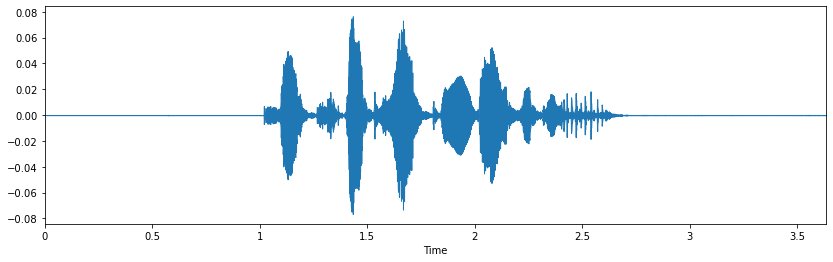

In [18]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

#### 4.2. Noise Injection

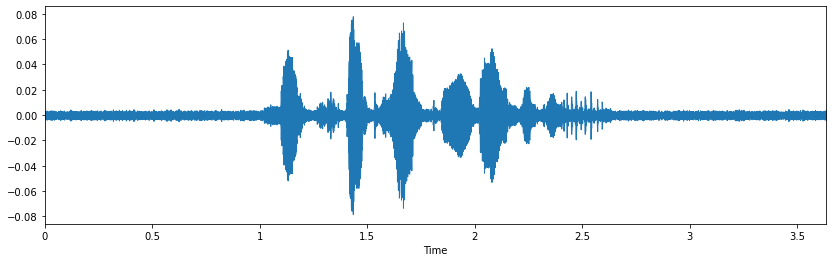

In [19]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

Noise injection proves to be an effective augmentation technique, as it introduces variability into the training data. By doing so, it helps prevent the model from overfitting, ensuring that it learns more generalized features rather than memorizing specific patterns from the training set. This ultimately improves the model's ability to perform well on unseen data.

#### 4.3. Stretching

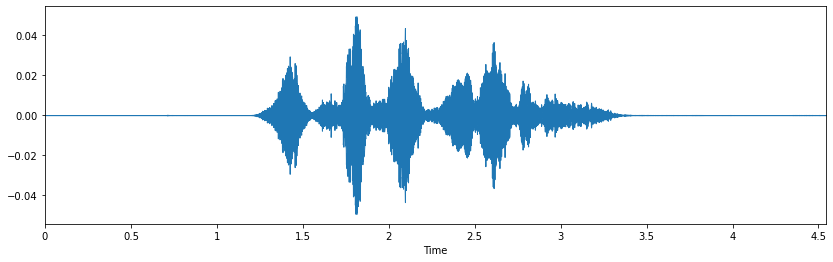

In [20]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4.4. Shifting

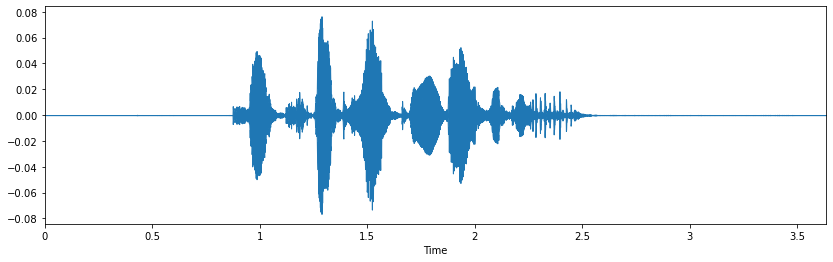

In [21]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4.5. Pitch

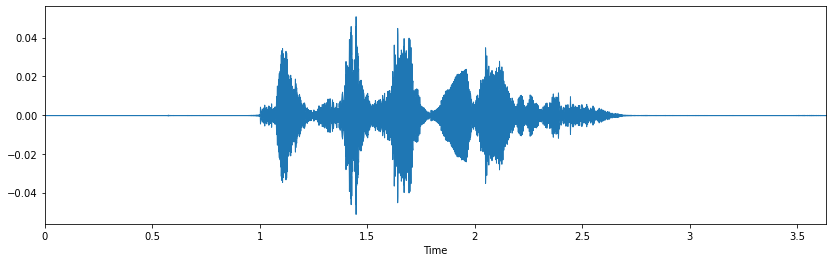

In [22]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

From the discussed augmentation techniques, I am implementing noise injection, speed adjustments (stretching), and pitch modifications.

### Step 5. Feature Extration

Feature extraction plays a crucial role in analyzing data and identifying relationships between different components. Since audio data is not directly understandable by models, feature extraction helps convert the audio signals into a format that can be processed by machine learning algorithms.

An audio signal is a three-dimensional representation, with time, amplitude, and frequency as the three axes.

We actually came across a really useful blog by Akash Mallik that covers feature extraction for audio signals, which helped me understand the process better. Based on this, I learned that with the sample rate and sample data, various transformations can be applied to extract valuable features. 

Reference to Article: [Audio signal feature extraction and clusteringk](https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225)

These include:

**Zero Crossing Rate:** The rate at which the signal changes its sign during a specific frame.
**Energy:** The sum of the squares of the signal values, normalized by the frame length.
Entropy of Energy: The entropy of normalized energies of sub-frames, indicating abrupt changes.
**Spectral Centroid:** The center of gravity of the spectrum.
**Spectral Spread:** The second central moment of the spectrum.
**Spectral Entropy:** Entropy of the normalized spectral energies across sub-frames.
**Spectral Flux:** The squared difference between the normalized magnitudes of successive frame spectra.
**Spectral Rolloff:** The frequency below which 90% of the spectrum’s magnitude is concentrated.
**MFCC (Mel Frequency Cepstral Coefficients):** A representation where frequency bands are distributed according to the mel-scale.
**Chroma Vector:** A 12-element representation of spectral energy corresponding to 12 pitch classes in western music.
**Chroma Deviation:** The standard deviation of the 12 chroma coefficients.

For this project, We are not diving deeply into the feature selection process to determine which features work best for the dataset. Instead, we will focus on extracting the following five features for model training:

1. **Zero Crossing Rate**
2. **Chroma_stft**
3. **MFCC**
4. **RMS (Root Mean Square) value**
5. **MelSpectrogram**

In [23]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

In [24]:
def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # Without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # Data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # Data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [25]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [26]:
len(X), len(Y), data_path.Path.shape

(36486, 36486, (12162,))

In [27]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.236364  0.682681  0.670631  0.614893  0.577180  0.557824  0.635630   
1  0.289442  0.692645  0.711370  0.681050  0.660677  0.710229  0.703727   
2  0.173148  0.671824  0.640110  0.576241  0.517699  0.501699  0.615085   
3  0.249344  0.623057  0.581343  0.598568  0.622959  0.593760  0.598832   
4  0.300465  0.669334  0.669826  0.724883  0.738514  0.707634  0.653989   

          7         8         9  ...       153       154       155       156  \
0  0.667002  0.664258  0.670328  ...  0.000234  0.000236  0.000138  0.000129   
1  0.702063  0.677469  0.685770  ...  0.000340  0.000331  0.000257  0.000245   
2  0.679769  0.680854  0.671641  ...  0.000044  0.000046  0.000047  0.000038   
3  0.650681  0.699159  0.683510  ...  0.000018  0.000016  0.000013  0.000012   
4  0.687386  0.725667  0.712537  ...  0.000114  0.000110  0.000110  0.000114   

        157       158       159       160           161    labels  
0  0.000300  0.000354  0.000212  0.000081  1.317474e-05  surprise  
1  0.000425  0.000468  0.000310  0.000184  1.164158e-04  surprise  
2  0.000026  0.000034  0.000044  0.000017  8.125645e-07  surprise  
3  0.000007  0.000008  0.000007  0.000002  2.394534e-07   neutral  
4  0.000109  0.000105  0.000105  0.000096  9.461165e-05   neutral  

[5 rows x 163 columns]

Hence, We have applied data augmentation techniques and extracted the features from each audio file, then saved them for further processing.

## Step 5: Data Preparation, Continued...

At this stage, we have extracted the data. The next step is to normalize the data and split it into training and testing sets.

In [28]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [29]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

### Step 6: Model Training and Evaluation

#### 6.1. Splitting Data into Train and Test Sets

In [30]:
# Splitting data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [31]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [32]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 8), (9122, 162, 1), (9122, 8))

#### 6.2. Creating CNN Architecture 

In [33]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 162, 256)          1536      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 81, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 81, 256)           327936    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 41, 256)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 41, 128)           163968    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 21, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 128)          

#### 6.3. Model Training

In [34]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Train on 27364 samples, validate on 9122 samples
Epoch 1/50
27364/27364 [==============================] - 7s 263us/step - loss: 1.7151 - accuracy: 0.3014 - val_loss: 1.4849 - val_accuracy: 0.4185
Epoch 2/50
27364/27364 [==============================] - 4s 140us/step - loss: 1.4874 - accuracy: 0.3993 - val_loss: 1.3403 - val_accuracy: 0.4535
Epoch 3/50
27364/27364 [==============================] - 4s 139us/step - loss: 1.4019 - accuracy: 0.4347 - val_loss: 1.3189 - val_accuracy: 0.4646
Epoch 4/50
27364/27364 [==============================] - 4s 139us/step - loss: 1.3425 - accuracy: 0.4614 - val_loss: 1.2265 - val_accuracy: 0.5035
Epoch 5/50
27364/27364 [==============================] - 4s 139us/step - loss: 1.2928 - accuracy: 0.4757 - val_loss: 1.1906 - val_accuracy: 0.5171
Epoch 6/50
27364/27364 [==============================] - 4s 139us/step - loss: 1.2611 - accuracy: 0.4896 - val_loss: 1.1909 - val_accuracy: 0.5176
Epoch 7/50
27364/27364 [==============================] - 4s 14

#### 6.4. Model training visualization

9122/9122 [==============================] - 1s 98us/step
Accuracy of our model on test data :  61.60929799079895 %


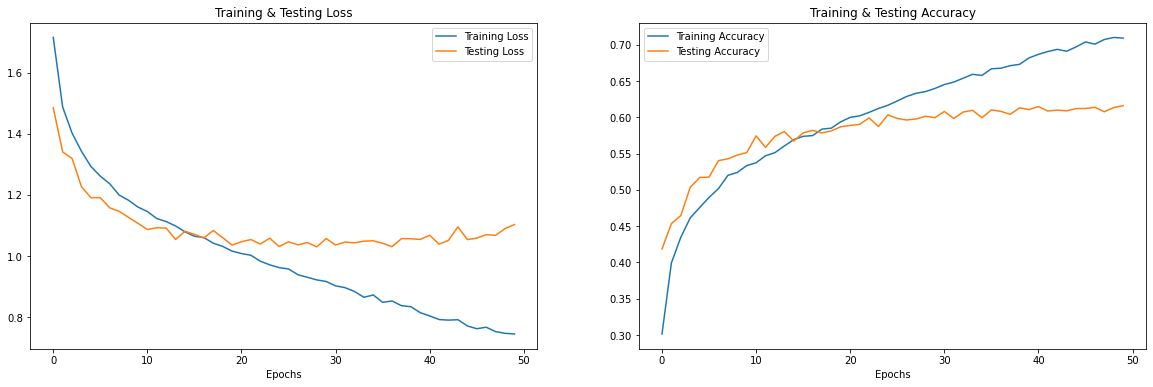

In [35]:
# visualizing train and test accuracy and loss
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

#### 6.5. Model Prediction - Testing on test dataset

In [36]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [37]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0          neutral       disgust
1          neutral       neutral
2             fear          fear
3            happy         angry
4            angry          fear
5              sad       disgust
6            angry         angry
7          disgust       disgust
8          neutral       disgust
9          neutral       neutral

#### 6.6. Confusion Matrix

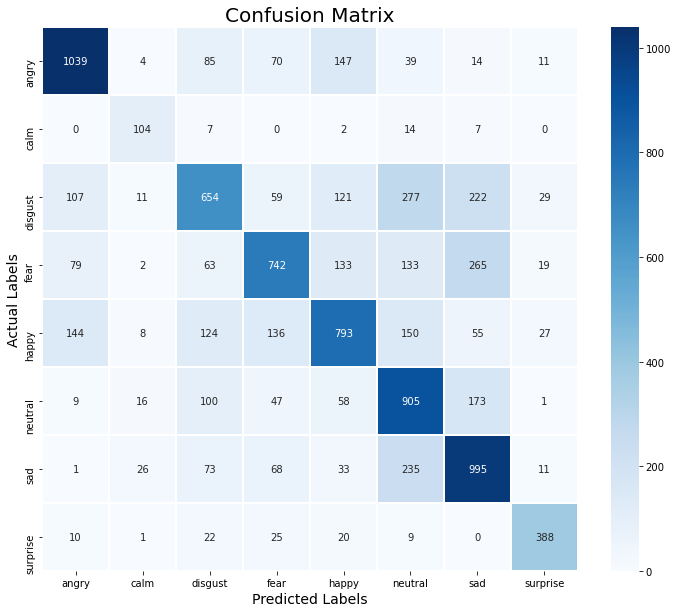

In [38]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

#### 6.7. Classification Report

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.75      0.74      0.74      1409
        calm       0.60      0.78      0.68       134
     disgust       0.58      0.44      0.50      1480
        fear       0.65      0.52      0.57      1436
       happy       0.61      0.55      0.58      1437
     neutral       0.51      0.69      0.59      1309
         sad       0.57      0.69      0.63      1442
    surprise       0.80      0.82      0.81       475

    accuracy                           0.62      9122
   macro avg       0.63      0.65      0.64      9122
weighted avg       0.62      0.62      0.61      9122



The classification report provides an evaluation of the model's performance across different emotion classes in terms of precision, recall, f1-score, and support. Here's a breakdown of each metric:

1. **Precision:** This indicates the percentage of correctly predicted positive instances out of all predicted positive instances for each emotion. For example, for the "angry" class, 79% of the instances predicted as angry were indeed angry.

2. **Recall:** This measures the percentage of correctly predicted positive instances out of all actual positive instances for each emotion. For example, for the "calm" class, 78% of the actual calm instances were correctly identified by the model.

3. **F1-Score:** The harmonic mean of precision and recall. This provides a balanced evaluation metric. For instance, the "angry" class has an F1-score of 0.73, which reflects a reasonable balance between precision and recall.

4. **Support:** The number of instances of each class in the dataset. For example, there are 1409 instances of "angry" and 134 instances of "calm."

#### Overall Evaluation:
* The accuracy of the model is 0.61, meaning the model correctly predicts the emotion 61% of the time across all classes.
* The macro average indicates an average precision, recall, and F1-score across all classes without considering class imbalance. It is 0.64 for precision, recall, and F1-score.
* The weighted average takes into account the support (class distribution) and calculates the overall performance based on this distribution. The weighted average precision, recall, and F1-score are all 0.61, which reflects a moderate performance, though improvements could be made.

#### Specific Observations:
* "Angry" and "Surprise" classes have relatively high precision and recall, with f1-scores of 0.73 and 0.84, respectively, suggesting that the model performs well in identifying these emotions.
* "Disgust" and "Fear" have lower F1-scores (around 0.51-0.57), indicating that the model struggles more with these emotions.
* "Calm" and "Happy" classes have balanced recall and precision but still show lower F1-scores around 0.55-0.70, suggesting room for improvement in distinguishing these emotions.

Overall, while the model shows good performance in identifying certain emotions like "angry" and "surprise," there are areas for improvement, especially with emotions like "disgust" and "fear," which require further tuning or additional techniques to improve classification accuracy.